In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

if project_root not in sys.path:
    print(f"Adding {project_root} to sys.path")
    sys.path.append(project_root)


Adding /vol/bitbucket/icc24/MSRGNN to sys.path


In [4]:
import pickle
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm.auto import tqdm
import importlib

from torch.utils.data import DataLoader, random_split, Subset

/vol/venv/icc24/DGL_ENV/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# I-RAVEN

In [ ]:
from data_utility_norm_viz import dataset

In [6]:
BATCH_SIZE = 32
# Replace this with the path to the dataset if the location differs
RAVEN_ROOT_DIR = "../../RAVEN/data10k"
IMG_SIZE = 80

In [ ]:
# --- DataLoaders ---
from types import SimpleNamespace
args = SimpleNamespace(
    path=RAVEN_ROOT_DIR,
    img_size=IMG_SIZE,
    percent=100,
)

transform = None

train_dataset = dataset(args, mode="train", rpm_types=['cs', 'io', 'lr', 'ud', 'd4', 'd9', '4c'], transform=transform, transform_p=0.0)
# train_dataset = dataset(args, mode="train", rpm_types=['cs'])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=6, pin_memory=True)

val_dataset = dataset(args, mode="val", rpm_types=['cs', 'io', 'lr', 'ud', 'd4', 'd9', '4c'])
# val_dataset = dataset(args, mode="val", rpm_types=['cs'])
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=6, pin_memory=True)

test_dataset = dataset(args, mode="test", rpm_types=['cs', 'io', 'lr', 'ud', 'd4', 'd9', '4c'])
# test_dataset = dataset(args, mode="test", rpm_types=['cs'])
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=6, pin_memory=True)



In [ ]:
def extract_target_indices(loader: DataLoader):
    """
    Iterates through a DataLoader to extract all target indices.
    
    Args:
        loader (DataLoader): The DataLoader to iterate through.
    """
    all_indices = []
    for _, targets in tqdm(loader, leave=False):
        all_indices.extend(targets.numpy())
    return all_indices

train_indices = extract_target_indices(train_loader)
val_indices = extract_target_indices(val_loader)
test_indices = extract_target_indices(test_loader)

all_target_indices = train_indices + val_indices + test_indices
total_samples = len(all_target_indices)
print(f"\nLabel extraction complete. Analyzing a total of {total_samples} samples.")

  0%|          | 0/1313 [00:00<?, ?it/s]


Label extraction complete. Analyzing a total of 70000 samples.


Generating bar chart for Target Index distribution...


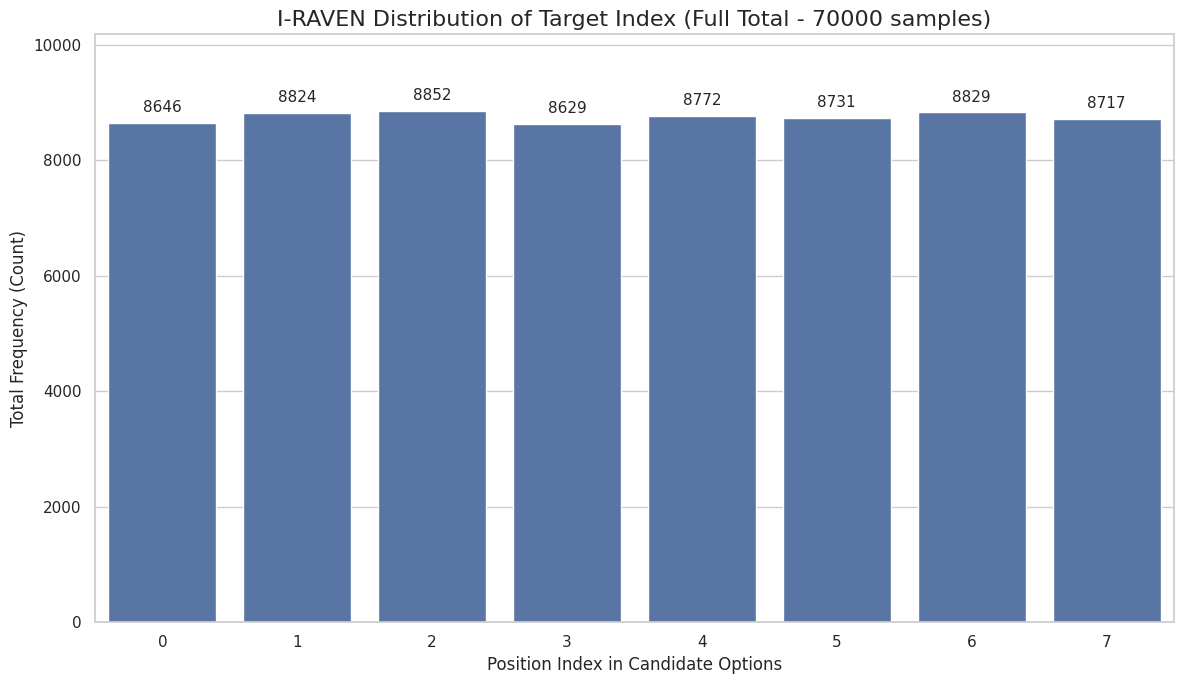

In [ ]:
print("Generating bar chart for Target Index distribution...")
plt.figure(figsize=(12, 7))
sns.set_theme(style="whitegrid", palette="deep")

possible_indices = list(range(8))

counts = pd.Series(all_target_indices).value_counts().reindex(possible_indices, fill_value=0)

ax = sns.barplot(x=counts.index, y=counts.values)

y_max = counts.max()
for i, count in enumerate(counts):
    ax.text(i, count + y_max * 0.015, f'{count}', ha='center', va='bottom', fontsize=11)

plt.title(f'I-RAVEN Distribution of Target Index (Full Total - {total_samples} samples)', fontsize=16)
plt.ylabel('Total Frequency (Count)', fontsize=12)
plt.xlabel('Position Index in Candidate Options', fontsize=12)
plt.xticks(ticks=possible_indices)
plt.ylim(0, y_max * 1.15)
plt.tight_layout()
plt.show()


Analyzing the composition of 70000 files...
Generating bar chart for RPM Type distribution...


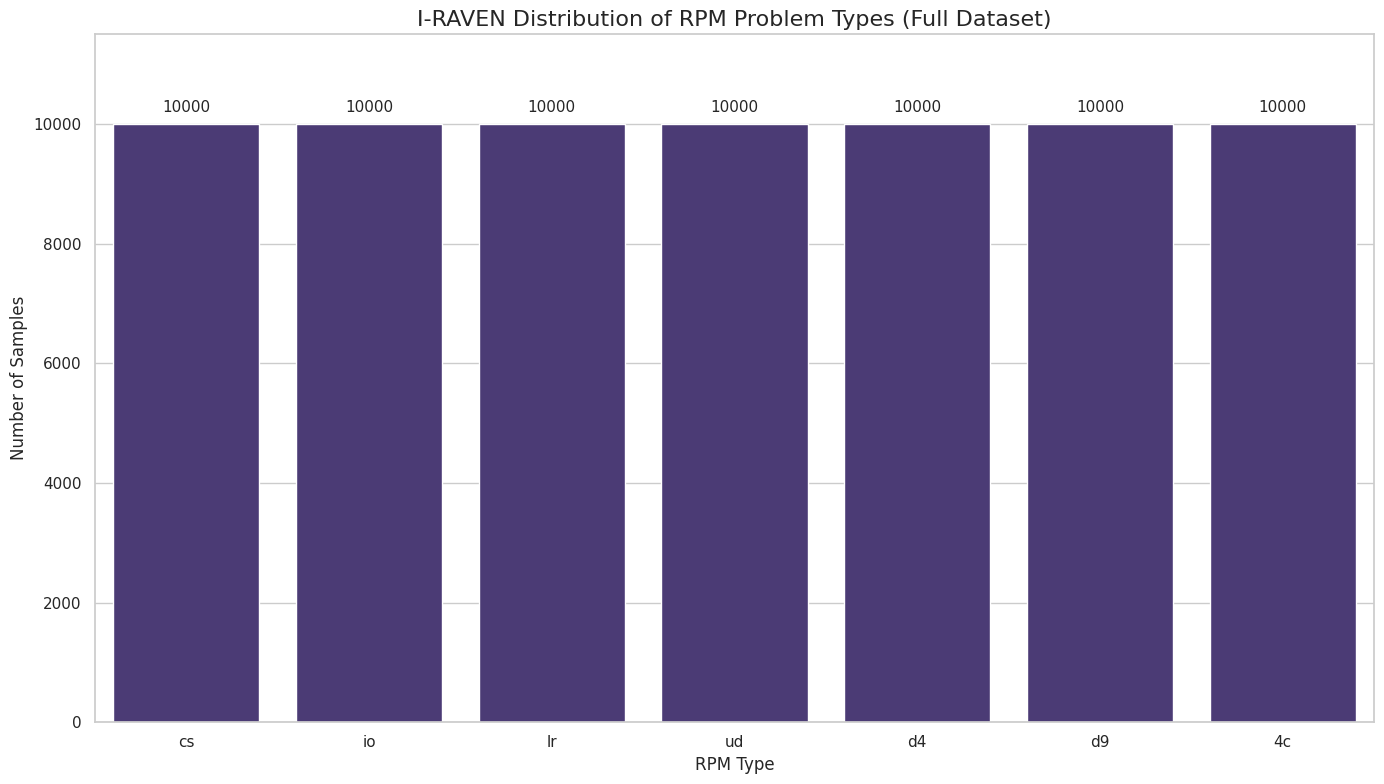

In [ ]:
from collections import Counter

rpm_folders = {'cs': "center_single",
               'io': "in_center_single_out_center_single",
               'ud': "up_center_single_down_center_single",
               'lr': "left_center_single_right_center_single",
               'd4': "distribute_four",
               'd9': "distribute_nine",
               '4c': "in_distribute_four_out_center_single",
               '*': '*'}

folder_to_rpm_type = {v: k for k, v in rpm_folders.items()}

def get_rpm_type_from_path(path):
    """Parses a file path to find the RPM folder name and map it to a type."""
    parts = path.replace('\\', '/').split('/')
    if len(parts) >= 2:
        folder_name = parts[-2]
        return folder_to_rpm_type.get(folder_name, 'unknown')
    return 'unknown'

all_files = train_dataset.file_names + val_dataset.file_names + test_dataset.file_names

all_rpm_types = [get_rpm_type_from_path(f) for f in all_files]
print(f"\nAnalyzing the composition of {len(all_rpm_types)} files...")

# Generate the Bar Chart of RPM Type Distribution
print("Generating bar chart for RPM Type distribution...")
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid", palette="viridis")

# Get counts of each RPM type
rpm_counts = pd.Series(all_rpm_types).value_counts()

# Create the bar plot
ax = sns.barplot(x=rpm_counts.index, y=rpm_counts.values, order=rpm_counts.index)

# Add count labels
y_max = rpm_counts.max()
for i, count in enumerate(rpm_counts):
    ax.text(i, count + y_max * 0.015, f'{count}', ha='center', va='bottom', fontsize=11)

# Set titles and labels
plt.title(f'I-RAVEN Distribution of RPM Problem Types (Full Dataset)', fontsize=16)
plt.ylabel('Number of Samples', fontsize=12)
plt.xlabel('RPM Type', fontsize=12)
plt.ylim(0, y_max * 1.15)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch

def visualize_problem(problem_sample, correct_answer_index, name=""):
    """
    Visualizes a single problem with the progression rule and a VISIBLE
    green box around the correct candidate answer.
    
    Args:
        problem_sample (tuple): A single item from RadioV2Dataset's __getitem__.
        correct_answer_index (int): The index of the correct answer.
        organ_class_names (list): A list of strings mapping organ indices to names.
    """
    images_tensor = problem_sample[0]
    images = images_tensor.squeeze().cpu().numpy()
    context_images = images[:8]
    candidate_images = images[8:]


    fig = plt.figure(figsize=(8, 8))
    fig.suptitle(name, fontsize=16, y=0.98)

    gs_main = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[3, 1], hspace=0.3)

    # Plot the 3x3 context grid ---
    gs_context = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs_main[0], wspace=0.1, hspace=0.1)
    for i in range(8):
        row, col = divmod(i, 3)
        ax = fig.add_subplot(gs_context[row, col])
        ax.imshow(context_images[i], cmap='gray')
        ax.axis('off')
    
    ax_missing = fig.add_subplot(gs_context[2, 2])
    ax_missing.text(0.5, 0.5, '?', fontsize=40, ha='center', va='center', color='lightgrey')
    ax_missing.axis('off')

    # Plot the 8 candidate answers ---
    gs_candidates = gridspec.GridSpecFromSubplotSpec(1, 8, subplot_spec=gs_main[1], wspace=0.1)

    for i in range(len(candidate_images)):
        ax = fig.add_subplot(gs_candidates[0, i])
        ax.imshow(candidate_images[i], cmap='gray')
        
        ax.set_xticks([])
        ax.set_yticks([])

        if i == correct_answer_index:
            for spine in ax.spines.values():
                spine.set_edgecolor('limegreen')
                spine.set_linewidth(4)
                spine.set_visible(True)
        else:
            for spine in ax.spines.values():
                spine.set_visible(False)

    plt.show()

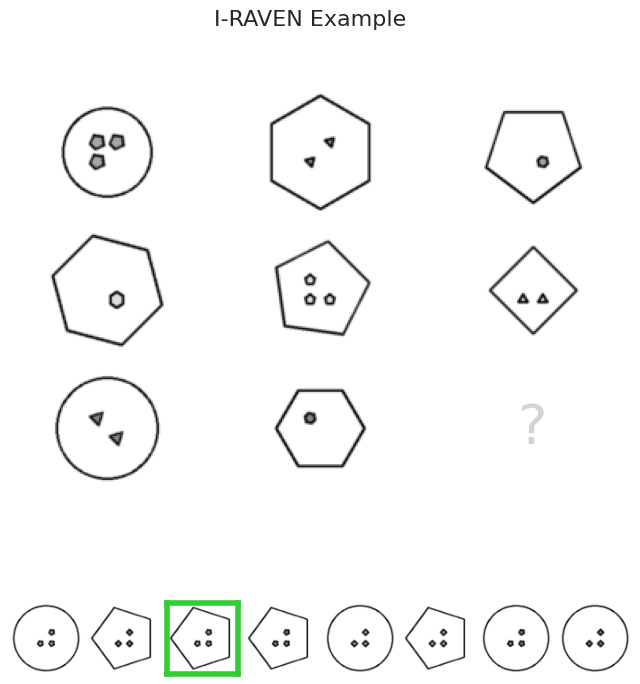

In [ ]:
sample_index = 40000
problem_sample = train_dataset[sample_index]

correct_answer_index = problem_sample[1].item()

visualize_problem(problem_sample, correct_answer_index, name="I-RAVEN Example")

In [ ]:
# Dictionary to store the activations from hooks
activations = {}

def get_activation(name):
    """
    This function returns a hook function that saves the output of a layer.
    """
    def hook(model, input, output):
        # Detach the output tensor to prevent holding onto the computation graph
        activations[name] = output.detach()
    return hook

def get_input_activation(name):
    """
    This function returns a hook function that saves the INPUT of a layer.
    Useful for getting data before a non-module function like F.dropout.
    """
    def hook(model, input, output):
        activations[name] = input[0].detach()
    return hook

In [ ]:
import networkx as nx

def visualize_attention_on_grid(ax, attention_matrix, edge_index, title, vmin, vmax):
    """
    Draws the GNN attention weights on a 3x3 grid using networkx, with curved edges.

    Args:
        ax (matplotlib.axes.Axes): The axes object to draw on.
        attention_matrix (np.array): The [9, 9] matrix of attention weights.
        edge_index (torch.Tensor): The [2, num_edges] tensor defining graph connections.
        title (str): The title for the plot.
        vmin (float): Minimum value for color mapping.
        vmax (float): Maximum value for color mapping.
    """
    num_nodes = attention_matrix.shape[0]
    if num_nodes != 9:
        ax.text(0.5, 0.5, "Visualization only for 9 nodes", ha='center', va='center')
        ax.set_title(title)
        return

    G = nx.DiGraph()
    pos = {i: (i % 3, -(i // 3)) for i in range(num_nodes)}
    
    edges = []
    weights = []
    
    for dest_node, src_node in edge_index.t().tolist():
        weight = attention_matrix[src_node, dest_node]
        if weight > 0.01:
            G.add_edge(src_node, dest_node, weight=weight)
            edges.append((src_node, dest_node))
            weights.append(weight)

    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=800, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold', ax=ax)
    
    if not weights:
        ax.set_title(title)
        ax.axis('off')
        return

    # Edge drawing with curves and colormap
    edge_cmap = plt.cm.plasma
    nx.draw_networkx_edges(
        G,
        pos,
        edgelist=edges,
        edge_color=weights,
        edge_cmap=edge_cmap,
        edge_vmin=vmin,
        edge_vmax=vmax,
        width=[w * 15 + 0.5 for w in weights],
        arrows=True,
        arrowstyle='-|>',
        arrowsize=20,
        node_size=800,
        connectionstyle='arc3,rad=0.15',
        ax=ax
    )

    ax.set_title(title, fontsize=14)
    ax.axis('off')

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import softmax
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec

plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "figure.titlesize": 16,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "image.interpolation": 'nearest',
    "font.family": "sans-serif",
})


def visualize_problem_instance(images, target_idx, predicted_idx):
    images = images.squeeze(1).cpu().numpy()
    context_panels = images[:8]
    candidate_panels = images[8:]

    fig = plt.figure(figsize=(6, 8.5), constrained_layout=True)
    # fig.suptitle("RPM Problem & Answer Candidates", fontsize=18, weight="bold")

    gs_main = GridSpec(2, 1, figure=fig, height_ratios=[3, 2], hspace=0.5)

    gs_context = gs_main[0].subgridspec(3, 3, wspace=0.05, hspace=0.05)
    for i in range(8):
        ax = fig.add_subplot(gs_context[i // 3, i % 3])
        ax.imshow(context_panels[i], cmap='gray', interpolation='nearest')
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_color('lightgray')
            spine.set_linewidth(1)

    ax_missing = fig.add_subplot(gs_context[2, 2])
    ax_missing.axis('off')
    ax_missing.text(0.5, 0.5, '?', ha='center', va='center', fontsize=40, color='black')

    gs_candidates = gs_main[1].subgridspec(2, 4, wspace=0.1, hspace=0.1)
    for i in range(8):
        ax = fig.add_subplot(gs_candidates[i // 4, i % 4])
        ax.imshow(candidate_panels[i], cmap='gray', interpolation='nearest')
        ax.set_xticks([])
        ax.set_yticks([])

        title = f"Candidate {i}"
        spine_color = 'lightgray'
        spine_width = 1.0

        if i == target_idx and i == predicted_idx:
            spine_color = '#4CAF50'
            spine_width = 4
        elif i == target_idx:
            spine_color = '#2196F3'
            spine_width = 4
        elif i == predicted_idx:
            spine_color = '#F44336'
            spine_width = 4

        ax.set_title(title, fontsize=10, y=-0.3)

        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_edgecolor(spine_color)
            spine.set_linewidth(spine_width)

    plt.show()

def visualize_feature_vectors_as_heatmap(vectors, name):
    """
    Visualizes captured 1D feature vectors for all 16 panels as a single heatmap.
    """
    vectors = vectors.squeeze().cpu().numpy()
    num_panels, num_features = vectors.shape

    fig, ax = plt.subplots(figsize=(12, 6))
    im = ax.imshow(vectors, cmap='viridis', aspect='auto')

    y_labels = [f"Ctx {i}" for i in range(8)] + [f"Cand {i}" for i in range(8)]
    ax.set_yticks(np.arange(num_panels))
    ax.set_yticklabels(y_labels)

    ax.set_title(f"Feature Vector Heatmap: {name}", fontsize=16, weight="bold")
    ax.set_xlabel(f"Feature Dimension ({num_features})")
    ax.set_ylabel("Panel")

    cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label("Feature Value")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


def get_attention_matrix(logits, single_edge_index, num_nodes=9):
    """Helper to calculate and format attention weights into a matrix."""
    dest_nodes = single_edge_index[0, :]
    attention_weights = softmax(logits.squeeze(-1), index=dest_nodes, num_nodes=num_nodes)
    attention_matrix = torch.zeros((num_nodes, num_nodes), device=logits.device)
    source_nodes = single_edge_index[1, :]
    attention_matrix[source_nodes, dest_nodes] = attention_weights
    return attention_matrix.cpu().numpy()


def visualize_attention_as_heatmap(ax, attention_matrix, title, vmin, vmax):
    """
    Visualizes a single attention matrix as a clean, readable heatmap
    using pcolormesh to prevent rendering artifacts (white grid lines).
    """
    im = ax.pcolormesh(
        attention_matrix,
        cmap='plasma',
        norm=Normalize(vmin=vmin, vmax=vmax)
    )
    ax.set_title(title, fontsize=14, weight="bold")

    ax.invert_yaxis()

    tick_labels = [f'{i}' for i in range(attention_matrix.shape[0])]
    ax.set_xticks(np.arange(attention_matrix.shape[1]) + 0.5)
    ax.set_yticks(np.arange(attention_matrix.shape[0]) + 0.5)
    ax.set_xticklabels(tick_labels)
    ax.set_yticklabels(tick_labels)

    ax.set_xlabel("Destination Node")
    ax.set_ylabel("Source Node")

    threshold = (vmax + vmin) / 2.0
    for i in range(attention_matrix.shape[0]):
        for j in range(attention_matrix.shape[1]):
            color = "white" if attention_matrix[i, j] < threshold else "black"
            ax.text(j + 0.5, i + 0.5, f'{attention_matrix[i, j]:.2f}',
                    ha="center", va="center", color=color, fontsize=7)

    return im



def visualize_attention_on_grid(ax, attention_matrix, edge_index, title, vmin, vmax):
    """Draws nodes on a 3x3 grid and connects them with lines colored by attention weight."""
    num_nodes = attention_matrix.shape[0]
    if num_nodes != 9:
        ax.text(0.5, 0.5, "Visualization only for 9 nodes", ha='center', va='center')
        ax.set_title(title, fontsize=12)
        return

    G = nx.DiGraph()
    pos = {i: (i % 3, -(i // 3)) for i in range(num_nodes)}

    edges, weights = [], []
    # Note: PyG edge_index is [destination, source]
    for dest_node, src_node in edge_index.t().tolist():
        weight = attention_matrix[src_node, dest_node]
        if weight > 0.01:
            G.add_edge(src_node, dest_node, weight=weight)
            edges.append((src_node, dest_node))
            weights.append(weight)

    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=600, ax=ax, edgecolors='black')
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', ax=ax)

    if weights:
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=edges,
            edge_color=weights,
            edge_cmap=plt.cm.plasma,
            edge_vmin=vmin,
            edge_vmax=vmax,
            width=[w * 12 + 0.5 for w in weights],
            arrows=True,
            arrowstyle='-|>',
            arrowsize=15,
            node_size=600,
            connectionstyle='arc3,rad=0.15',
            ax=ax
        )
    ax.set_title(title, fontsize=14, weight="bold")
    ax.axis('off')


def visualize_attention_weights(model, target_idx, predicted_idx, activations, num_nodes=9):
    """
    Visualizes GNN attention for the PREDICTED answer using a combined
    grid graph and heatmap plot.
    """
    for stage_name in ['gnn_stage1_logits', 'gnn_stage2_logits']:
        if stage_name not in activations:
            continue

        all_logits = activations[stage_name]
        logits_per_graph = all_logits.view(model.cand_size, -1, 1)
        attn_matrix_pred = get_attention_matrix(logits_per_graph[predicted_idx], model.template_edge_index, num_nodes)

        vmin = attn_matrix_pred.min()
        vmax = attn_matrix_pred.max()

        fig, axes = plt.subplots(1, 2, figsize=(16, 7), constrained_layout=True)
        stage_title = stage_name.replace('_logits', '').upper()
        # fig.suptitle(f"Attention Analysis for Predicted Answer (Cand. {predicted_idx}) - {stage_title}", fontsize=18, weight="bold")

        # Plot 1: Grid graph on the left subplot (axes[0])
        visualize_attention_on_grid(
            axes[0], attn_matrix_pred, model.template_edge_index,
            "Attention as a Graph", vmin, vmax
        )

        # Plot 2: Heatmap on the right subplot (axes[1])
        im = visualize_attention_as_heatmap(
            axes[1], attn_matrix_pred,
            "Attention as a Heatmap", vmin, vmax
        )

        # Add a single, shared colorbar for the figure
        cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.75, pad=0.02, orientation='vertical')
        cbar.set_label("Attention Weight", fontsize=12)

        plt.show()

In [136]:
def visualize_first_row_pools(images, activations):
    """
    Visualize the first row of 3 context panels from the RPM problem,
    showing raw image, 4x4, 2x2, and 1x1 pooled feature maps stacked.
    Color scales are fixed per pool type (like previous plots).
    """
    images = images.squeeze(1).cpu().numpy()
    context_panels = images[:8]
    first_row_idx = [0, 1, 2]
    pool_names = ['pool_4x4', 'pool_2x2', 'pool_1x1']

    # Precompute vmin/vmax per pool
    pool_vminmax = {}
    for pool_name in pool_names:
        if pool_name in activations:
            fmap = activations[pool_name].cpu()
            if fmap.dim() == 4:
                vis_map = fmap.mean(dim=1).detach().numpy()
            elif fmap.dim() == 2:
                vis_map = fmap.detach().numpy()[:, None, None]
            pool_vminmax[pool_name] = (vis_map.min(), vis_map.max())

    num_rows = len(pool_names) + 1
    num_cols = len(first_row_idx)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 3*num_rows), constrained_layout=True)
    # fig.suptitle("Progressive Pooling: First Row of Context Panels", fontsize=18, fontweight='bold')

    for col_idx, panel_idx in enumerate(first_row_idx):
        # Row 0: raw image
        axes[0, col_idx].imshow(context_panels[panel_idx], cmap='gray')
        axes[0, col_idx].set_title(f"Context {panel_idx}", fontsize=12)
        axes[0, col_idx].axis('off')

        # Rows 1..3: pooled maps
        for row_idx, pool_name in enumerate(pool_names, start=1):
            if pool_name not in activations:
                axes[row_idx, col_idx].axis('off')
                continue

            fmap = activations[pool_name].cpu()
            if fmap.dim() == 4:
                vis_map = fmap.mean(dim=1).detach().numpy()
            elif fmap.dim() == 2:
                vis_map = fmap.detach().numpy()[:, None, None]

            panel_map = vis_map[panel_idx]
            if panel_map.ndim == 1:
                panel_map = panel_map.reshape(1, 1)

            vmin, vmax = pool_vminmax[pool_name]
            axes[row_idx, col_idx].imshow(panel_map, cmap='viridis', interpolation='nearest', vmin=vmin, vmax=vmax)
            axes[row_idx, col_idx].set_title(pool_name, fontsize=10)
            axes[row_idx, col_idx].axis('off')

    plt.show()


In [1]:
from msrgnn_viz import MSRGNN

torch.Size([1, 16, 1, 80, 80])
Ground Truth Answer Index: 0
Model Predicted Answer Index: 0
Prediction is CORRECT!


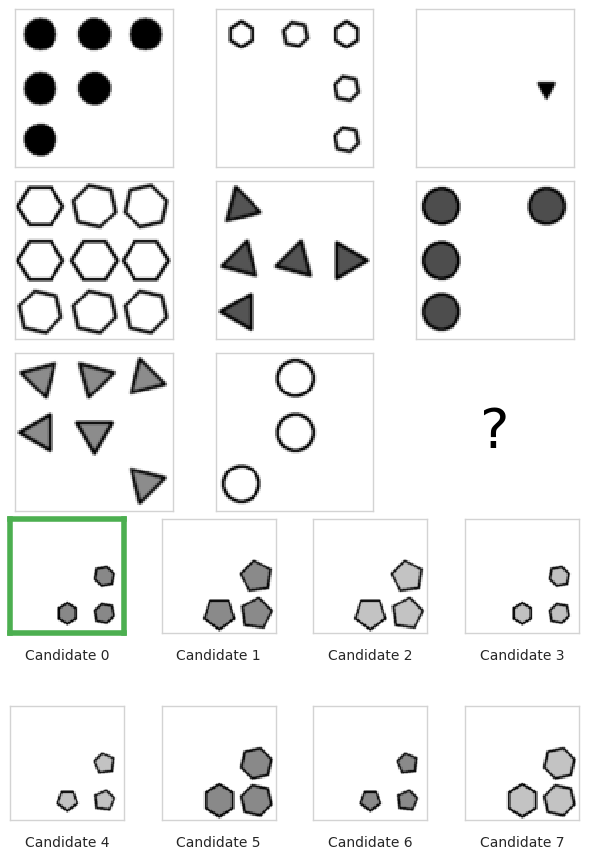

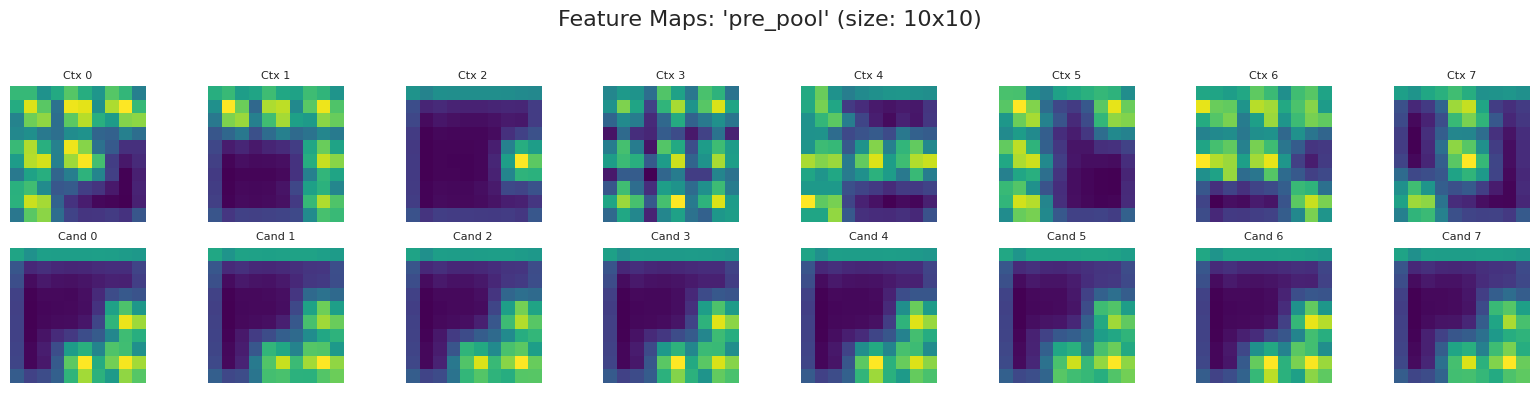

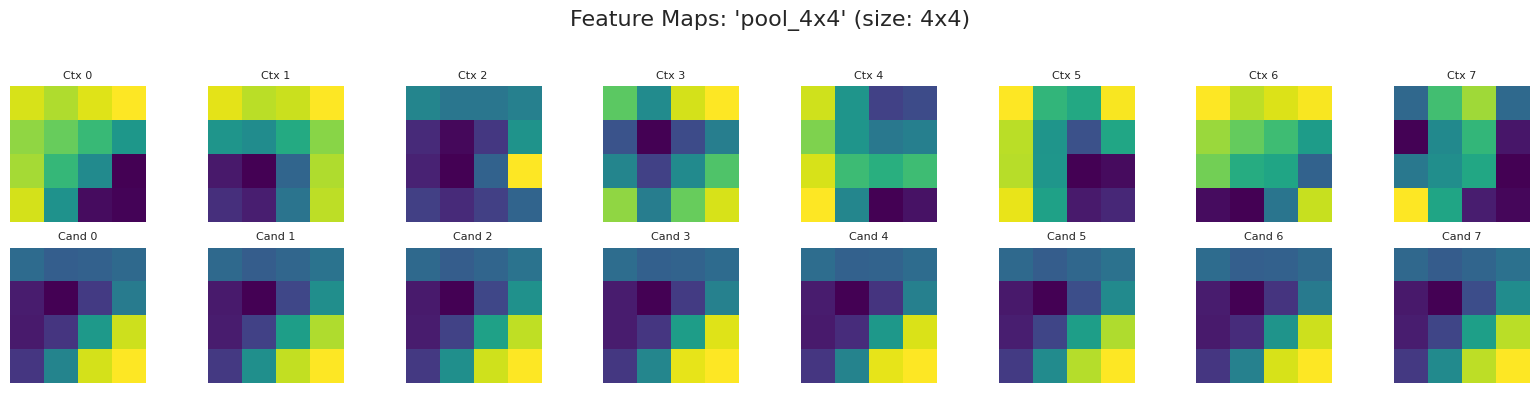

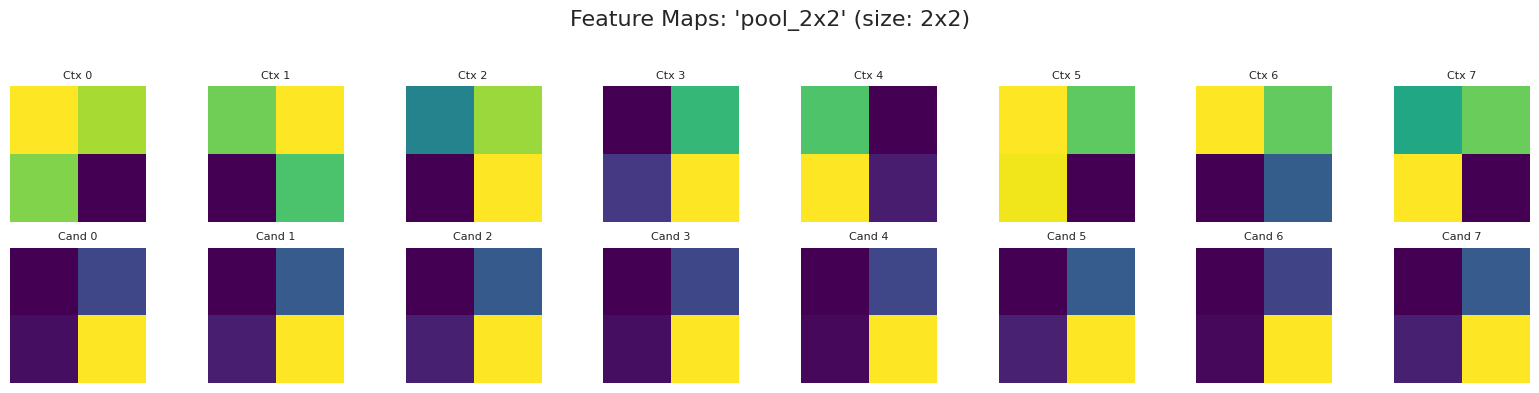

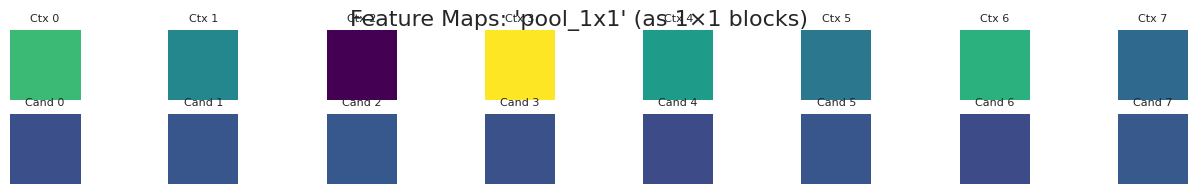

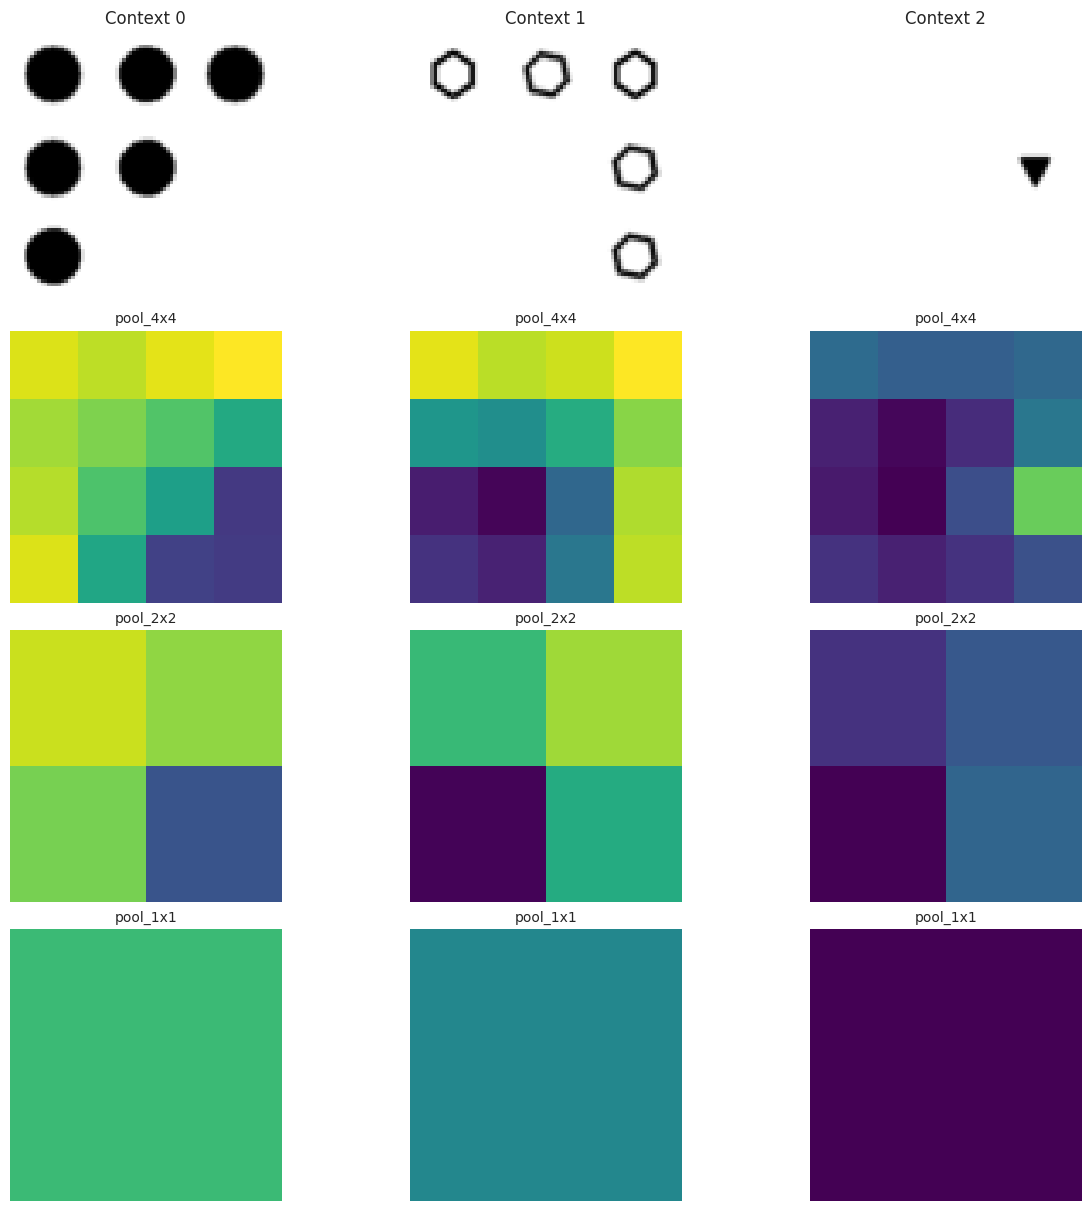

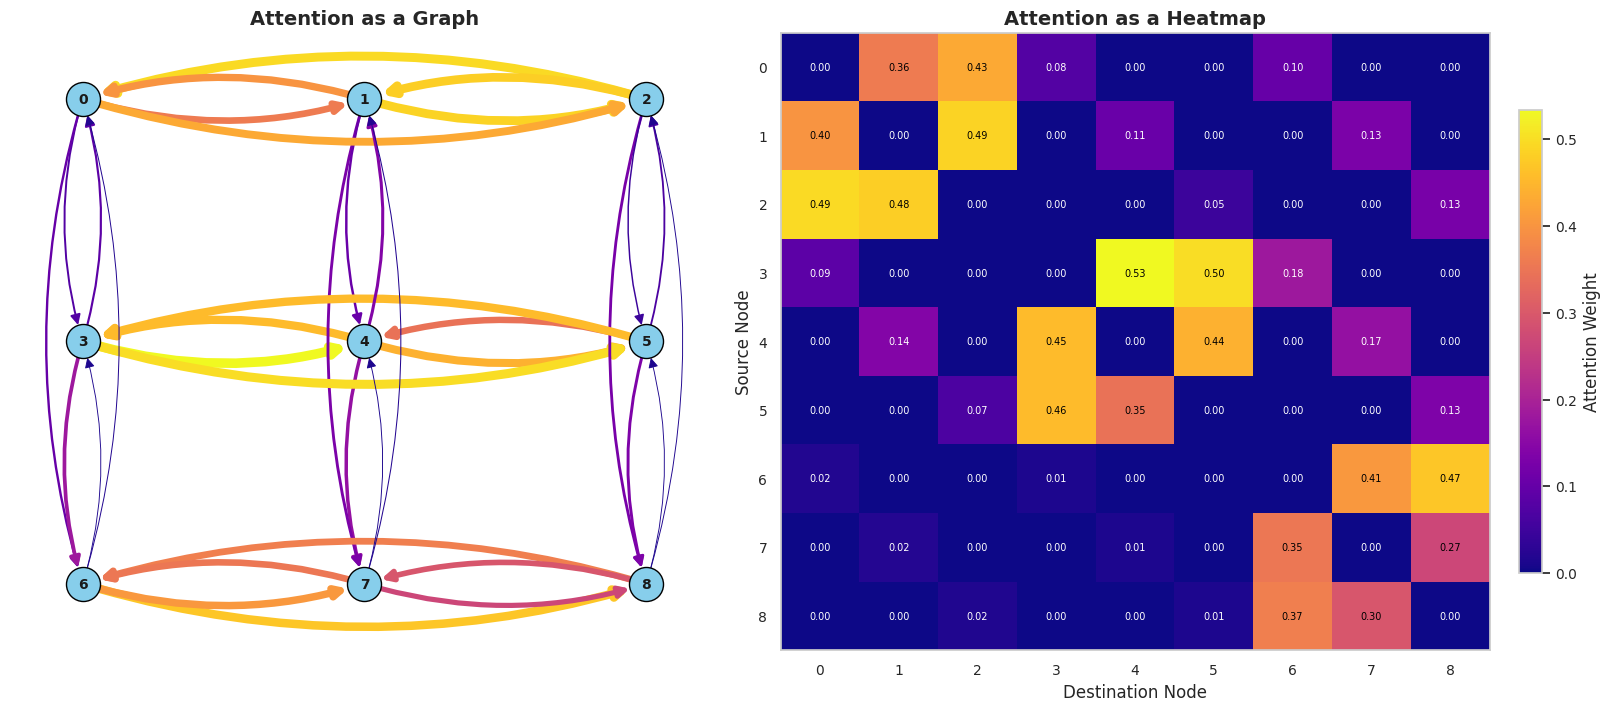

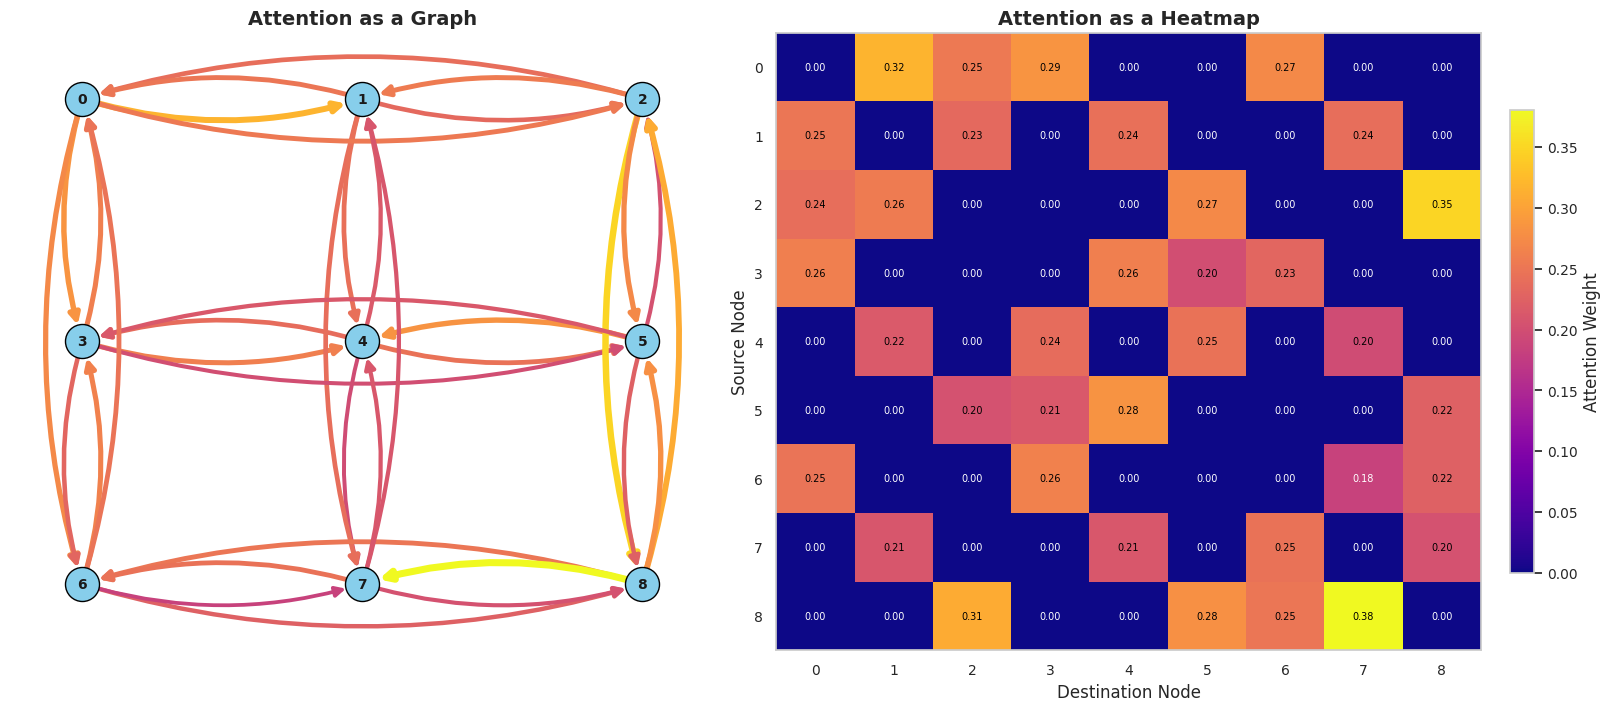

In [ ]:
data_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=6, pin_memory=True)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

try:
    images, target = next(iter(data_loader))
except StopIteration:
    print("Dataset is empty. Please check your data path and files.")
    exit()

images, target = test_dataset[11200]
images.unsqueeze_(0)

print(images.shape)

images, target = images.to(device), target.to(device)
target_idx = target.item()

model_params = {
        'ctx_size': 8,
        'cand_size': 8,
        'resnet_base_channels': 64,
        'pos_embedding_dim': 128,
        'gnn_hidden_dim': 128,
        'relation_net_mlp_layers': 3,
        'relation_net_dropout': 0,
        'gnn_message_dropout_p': 0,
        'reasoner_proj_dropout': 0,
    }
model = MSRGNN(
    **model_params
)

model.load_state_dict(
    torch.load(
        "../I_RAVEN/saved_models/best_model_msrgnn.pth"
    )
)

model.eval()

# Register hooks on the ResNet feature extractor
model.extractor.layer3.register_forward_hook(get_activation('pre_pool'))
model.extractor.pools['pool_4x4'].register_forward_hook(get_activation('pool_4x4'))
model.extractor.pools['pool_2x2'].register_forward_hook(get_activation('pool_2x2'))
model.extractor.pools['pool_1x1'].register_forward_hook(get_activation('pool_1x1'))

# Register hooks to capture the attention logits from both GNN layers.
# We hook the `attention_mlp` which produces the logits right before the softmax.
model.reasoner.shared_gnn_stage1.attention_mlp.register_forward_hook(get_activation('gnn_stage1_logits'))
model.reasoner.gnn_stage2.attention_mlp.register_forward_hook(get_activation('gnn_stage2_logits'))

# Run Model and Get Prediction ---
with torch.no_grad():
    output_scores = model(images, ctx_size=8, cand_size=8)

predicted_idx = torch.argmax(output_scores, dim=1).item()

print(f"Ground Truth Answer Index: {target_idx}")
print(f"Model Predicted Answer Index: {predicted_idx}")
if target_idx == predicted_idx:
    print("Prediction is CORRECT!")
else:
    print("Prediction is INCORRECT.")

visualize_problem_instance(images.cpu()[0], target_idx, predicted_idx)

visualize_feature_maps(activations=activations, num_total_panels=16)

visualize_first_row_pools(images.cpu()[0], activations=activations)

visualize_attention_weights(model, target_idx, predicted_idx, num_nodes=9, activations=activations)